In [2]:
# --- IMPORTS ---
import numpy as np
import stackstac
import pystac_client
import planetary_computer
import xrspatial.multispectral as ms
import dask.array as da
from dask.distributed import Client, LocalCluster
from urllib3.util.retry import Retry
from dask.diagnostics import ProgressBar
import xarray as xr
import bottleneck
import matplotlib.pyplot as plt
import matplotlib as mpl
import rioxarray
import os
import ipyleaflet


# --- PARAMETERS ---
# Choose how to group the time dimension: "month", "week", or "year"
time_grouping = "month"  # Options: "month", "week", "year"
spatial_resolution = 30  # Spatial resolution in meters
bands_to_load = ['B02', 'B03', 'B04', 'SCL']  # Blue, Green, Red, Scene Classification
local_cluster = True  # Set to False if using Coiled

In [3]:

# --- DASK CLUSTER SETUP ---
if local_cluster:
    cluster = LocalCluster()
    client = Client(cluster)
else:
    import coiled
    cluster = coiled.Cluster(name="Timelapse", shutdown_on_close=True)
    cluster.adapt(n_workers=1, maximum=8)
    client = cluster.get_client()


In [4]:

# --- MAP FOR BOUNDING BOX SELECTION ---
m = ipyleaflet.Map(scroll_wheel_zoom=True)
m.center = (41.64933994767867, -69.94438630063088)
m.zoom = 12
m.layout.height = "500px"
m.layout.width = "500px"
display(m)


Map(center=[41.64933994767867, -69.94438630063088], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [8]:

# Wait for user to select area, then get bounding box
# (You may want to add a widget for interactive selection in a real workflow)
bounding_box = (m.west, m.south, m.east, m.north)


In [14]:

# --- LOAD DATA FROM PLANETARY COMPUTER ---
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bounding_box,
    datetime="2024-01-01/2024-12-31"
)
items = search.item_collection()
print(f"Found {len(items)} items in the selected area and time range.")


Found 75 items in the selected area and time range.


In [15]:

# Stack the data using stackstac
data = stackstac.stack(
    items,
    assets=bands_to_load,
    resolution=spatial_resolution,
    epsg=3857,
    bounds_latlon=bounding_box
)

print("Array size information:")
print(f"Shape: {data.shape}")
print(f"Size in bytes: {data.data.nbytes}")
print(f"Size in GB: {data.data.nbytes / 1e9:.2f} GB")
print(f"Number of chunks: {data.data.npartitions}")
print(f"Chunksize: {(data.data.nbytes / data.data.npartitions) / 1e6:.2f} MB")

data


Array size information:
Shape: (75, 4, 638, 638)
Size in bytes: 976905600
Size in GB: 0.98 GB
Number of chunks: 300
Chunksize: 3.26 MB


<xarray.DataArray 'stackstac-885543fc267b8ed29ceb3885e4a6475d' (time: 75,
                                                                band: 4,
                                                                y: 638, x: 638)> Size: 977MB
dask.array<fetch_raster_window, shape=(75, 4, 638, 638), dtype=float64, chunksize=(1, 1, 638, 638), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 600B 2024-...
    id                                       (time) <U54 16kB 'S2A_MSIL2A_202...
  * band                                     (band) <U3 48B 'B02' ... 'SCL'
  * x                                        (x) float64 5kB -7.8e+06 ... -7....
  * y                                        (y) float64 5kB 5.123e+06 ... 5....
    s2:product_uri                           (time) <U65 20kB 'S2A_MSIL2A_202...
    ...                                       ...
    title                                    (band) <U29 464B 'Band 2 - Blue ...
    gsd                                      (band) float64 32B 10.0 ... 20.0
    common_name                              (band) object 32B 'blue' ... None
    center_wavelength                        (band) object 32B 0.49 ... None
    full_width_half_max                      (band) object 32B 0.098 ... None
    epsg                                     int32 4B 3857
Attributes:
    spec:        RasterSpec(epsg=3857, bounds=(-7799610, 5104080, -7780470, 5...
    crs:         epsg:3857
    transform:   | 30.00, 0.00,-7799610.00|\n| 0.00,-30.00, 5123220.00|\n| 0....
    resolution:  30

In [18]:

# --- Daily Composite Calculation (Using Resample) ---

# Establish SCL band on its own
scl_band = data.sel(band='SCL')

# Establish spectral bands on their own
spectral_bands = data.drop_sel(band = 'SCL')

# --- 1. Process Spectral Bands using resample (Simpler) ---
print("--- Calculating daily median for spectral bands using resample ---")
spectral_median = spectral_bands.resample(time="1D").median(skipna=True)


# --- 2. Process SCL Band (Still requires a custom Dask-aware function) ---
print("--- Calculating daily mode for SCL band ---")

def mode_using_bincount(arr):
    """A fast, NumPy-based function to find the mode of a 1D array of integers."""
    valid_data = arr[~np.isnan(arr)]
    if valid_data.size == 0:
        return np.nan
    return np.bincount(valid_data.astype(int)).argmax()

def dask_mode_runner(group):
    """Applies the mode calculation along the time axis in a parallel, Dask-friendly way."""
    result_dask_array = da.apply_along_axis(
        mode_using_bincount,
        axis=0,
        arr=group.data
    ).astype(np.uint8)
    return xr.DataArray(
        result_dask_array,
        coords={"y": group.coords["y"], "x": group.coords["x"]},
        dims=["y", "x"],
    )

scl_mode = scl_band.resample(time="1D").apply(dask_mode_runner)


# --- 3. Combine the results ---
print("--- Combining spectral and SCL bands ---")

# --- THIS IS THE FIX ---
# The spectral_median array inherited band-specific coordinates that scl_mode doesn't have.
# We drop them to make the two arrays compatible for concatenation.
# Using errors='ignore' prevents an error if a coordinate doesn't exist.
coords_to_drop = ['title', 'common_name', 'center_wavelength', 'full_width_half_max', 'gsd']
spectral_median = spectral_median.drop_vars(coords_to_drop, errors='ignore')


# Assign the band coordinate to the SCL data before concatenating
scl_mode = scl_mode.assign_coords(band='SCL')

# Concatenate along the band dimension. Both arrays now have matching coordinates.
clean_data = xr.concat([spectral_median, scl_mode], dim='band')

# ffill/bfill is still a good idea to handle days where only one type of data existed
clean_data = clean_data.ffill("time").bfill("time")

--- Calculating daily median for spectral bands using resample ---
--- Calculating daily mode for SCL band ---
--- Combining spectral and SCL bands ---


In [19]:

clean_data

<xarray.DataArray 'stackstac-885543fc267b8ed29ceb3885e4a6475d' (time: 361,
                                                                band: 4,
                                                                y: 638, x: 638)> Size: 5GB
dask.array<getitem, shape=(361, 4, 638, 638), dtype=float64, chunksize=(1, 1, 638, 638), chunktype=numpy.ndarray>
Coordinates: (12/15)
  * band                                     (band) <U3 48B 'B02' ... 'SCL'
  * x                                        (x) float64 5kB -7.8e+06 ... -7....
  * y                                        (y) float64 5kB 5.123e+06 ... 5....
  * time                                     (time) datetime64[ns] 3kB 2024-0...
    s2:saturated_defective_pixel_percentage  float64 8B 0.0
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    ...                                       ...
    sat:relative_orbit                       int32 4B 111
    instruments                              <U3 12B 'msi'
    s2:product_type                          <U7 28B 'S2MSI2A'
    proj:code                                <U10 40B 'EPSG:32619'
    proj:bbox                                object 8B {399960.0, 509760.0, 4...
    epsg                                     int32 4B 3857
Attributes:
    spec:        RasterSpec(epsg=3857, bounds=(-7799610, 5104080, -7780470, 5...
    crs:         epsg:3857
    transform:   | 30.00, 0.00,-7799610.00|\n| 0.00,-30.00, 5123220.00|\n| 0....
    resolution:  30

In [21]:


# --- GROUPING LOGIC ---
grouping_dict = {
    "month": "time.month",
    "week": "time.week",
    "year": "time.year"
}
if time_grouping not in grouping_dict:
    raise ValueError(f"Invalid time_grouping: {time_grouping}. Choose from {list(grouping_dict.keys())}")

grouping_accessor = grouping_dict[time_grouping]


# --- GOOD PIXEL CALCULATION ---
classification = clean_data.sel(band="SCL").squeeze(drop=True)
good_classes = [4, 5, 6]  # 4: Vegetation, 5: Not Vegetated, 6: Water
good_pixels = classification.isin(good_classes)
good_pixel_count = good_pixels.sum(dim=["x", "y"])
valid_pixel_count = (classification != 0).sum(dim=["x", "y"])
good_pixel_percentage = ((good_pixel_count / valid_pixel_count) * 100).fillna(0)

# --- COMPUTE PERCENTAGES ---
good_pixel_percentage = good_pixel_percentage.compute()

# --- SELECT BEST TIME STEP IN EACH GROUP ---
def select_best_in_group(group):
    """Selects the time step with the highest percentage of good pixels in a group."""
    return group.isel(time=group.argmax(dim="time"))

best_entries = good_pixel_percentage.groupby(grouping_accessor).apply(select_best_in_group)
best_timestamps = best_entries.time.values
best_time_group_data = clean_data.sel(time=best_timestamps)
best_time_group_data = best_time_group_data.persist()

print(f"Selected best time step for each {time_grouping}.")
best_time_group_data

Selected best time step for each month.


<xarray.DataArray 'stackstac-885543fc267b8ed29ceb3885e4a6475d' (time: 12,
                                                                band: 4,
                                                                y: 638, x: 638)> Size: 156MB
dask.array<getitem, shape=(12, 4, 638, 638), dtype=float64, chunksize=(1, 1, 638, 638), chunktype=numpy.ndarray>
Coordinates: (12/15)
  * band                                     (band) <U3 48B 'B02' ... 'SCL'
  * x                                        (x) float64 5kB -7.8e+06 ... -7....
  * y                                        (y) float64 5kB 5.123e+06 ... 5....
  * time                                     (time) datetime64[ns] 96B 2024-0...
    s2:saturated_defective_pixel_percentage  float64 8B 0.0
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    ...                                       ...
    sat:relative_orbit                       int32 4B 111
    instruments                              <U3 12B 'msi'
    s2:product_type                          <U7 28B 'S2MSI2A'
    proj:code                                <U10 40B 'EPSG:32619'
    proj:bbox                                object 8B {399960.0, 509760.0, 4...
    epsg                                     int32 4B 3857
Attributes:
    spec:        RasterSpec(epsg=3857, bounds=(-7799610, 5104080, -7780470, 5...
    crs:         epsg:3857
    transform:   | 30.00, 0.00,-7799610.00|\n| 0.00,-30.00, 5123220.00|\n| 0....
    resolution:  30

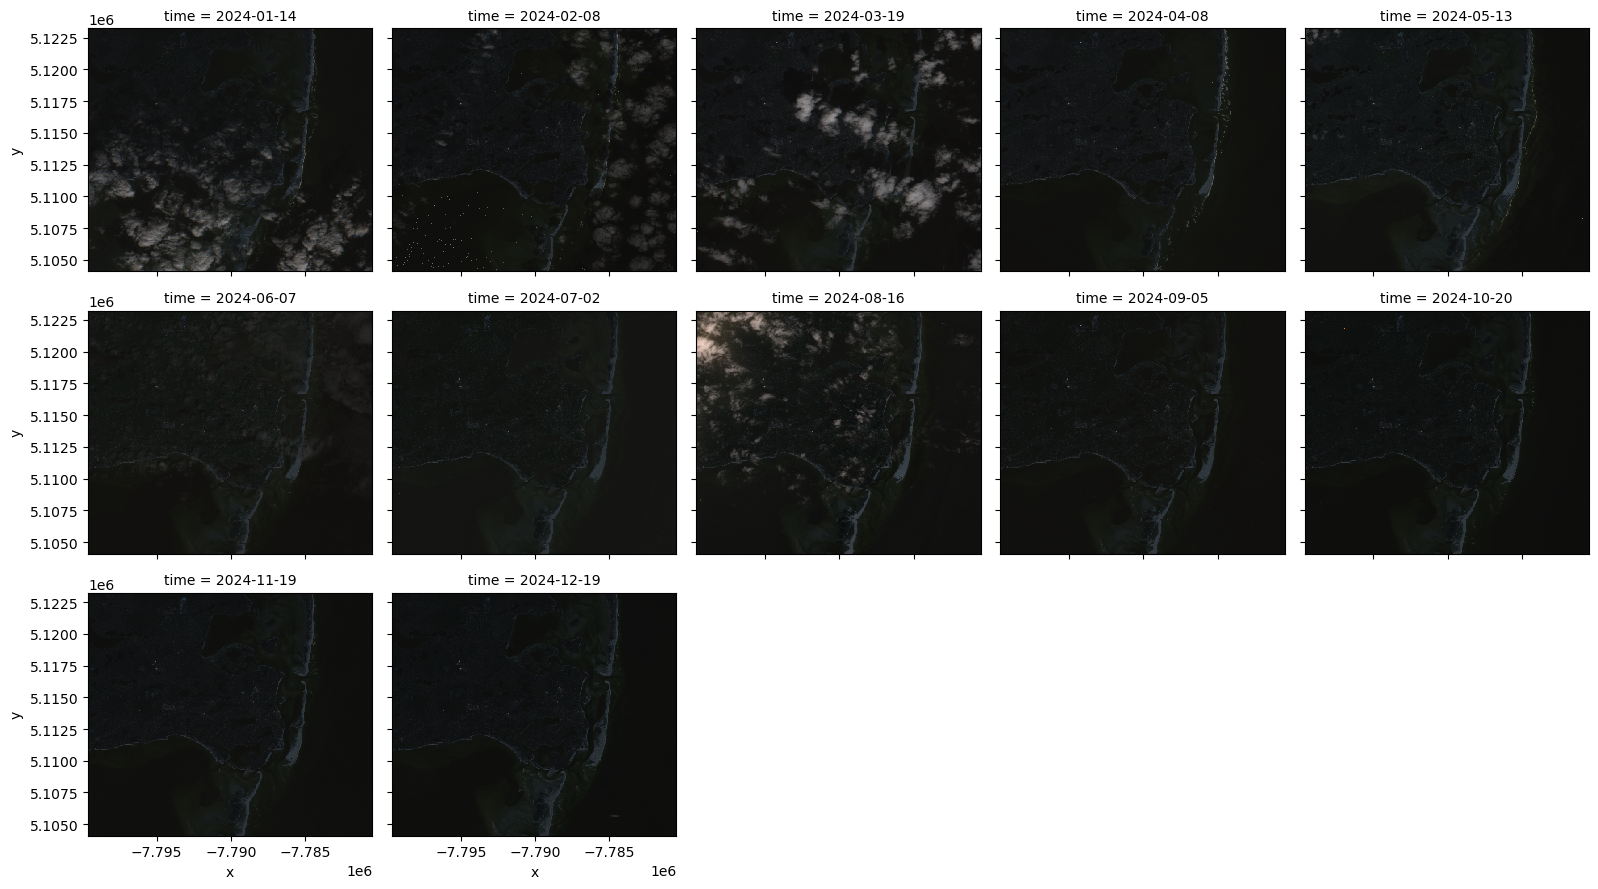

In [22]:
# Calculate global min and max for consistent scaling across all time steps
rgb_data = best_time_group_data.sel(band=['B02', 'B03', 'B04'])
global_min = rgb_data.min().compute()
global_max = rgb_data.max().compute()

# Plot with consistent vmin and vmax across all subplots
rgb_data.plot.imshow(
    col="time", 
    rgb="band", 
    col_wrap=5,
    vmin=global_min,
    vmax=global_max
)

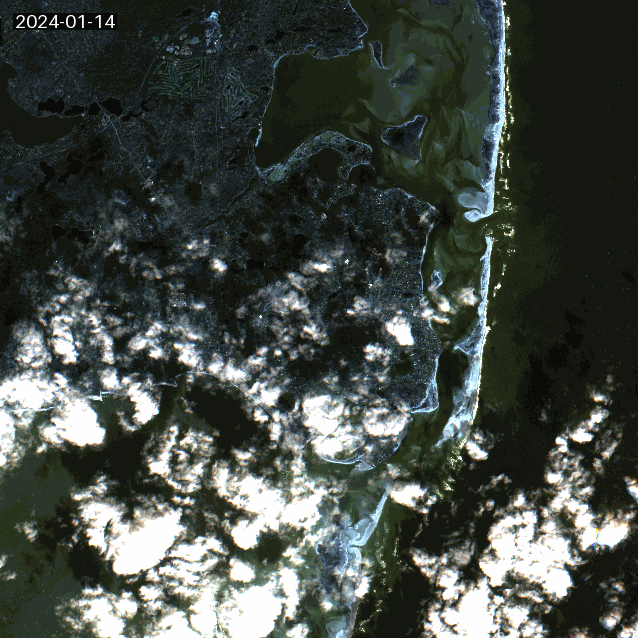

In [24]:
# Import geogif for creating animated GIFs from geospatial data
import geogif

geogif = geogif.dgif(rgb_data, fps=4)
geogif.compute()